In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


In [ ]:
import pandas as pd
data=pd.read_csv('exchange_rate.csv')
data.head

<bound method NDFrame.head of     time  exchange_rate
0   1986      22.936728
1   1987      78.953316
2   1988     611.646087
3   1989    4501.686529
4   1990    6537.604686
5   1991   10121.893230
6   1992   11202.191670
7   1993   10640.958330
8   1994   10965.666670
9   1995   11038.250000
10  1996   11032.583330
11  1997   11683.333330
12  1998   13268.000000
13  1999   13943.166670
14  2000   14167.750000
15  2001   14725.166670
16  2002   15279.500000
17  2003   15509.583330
18  2004   15746.000000
19  2005   15858.916670
20  2006   15994.250000
21  2007   16105.125000
22  2008   16302.250000
23  2009   17065.083330
24  2010   18612.916670
25  2011   20509.750000
26  2012   20828.000000
27  2013   20933.416670
28  2014   21148.000000
29  2015   21697.567500
30  2016   21935.000830
31  2017   22370.086670
32  2018   22602.050000
33  2019   23050.241670
34  2020   23208.368330
35  2021   23159.782590
36  2022   23271.212500>

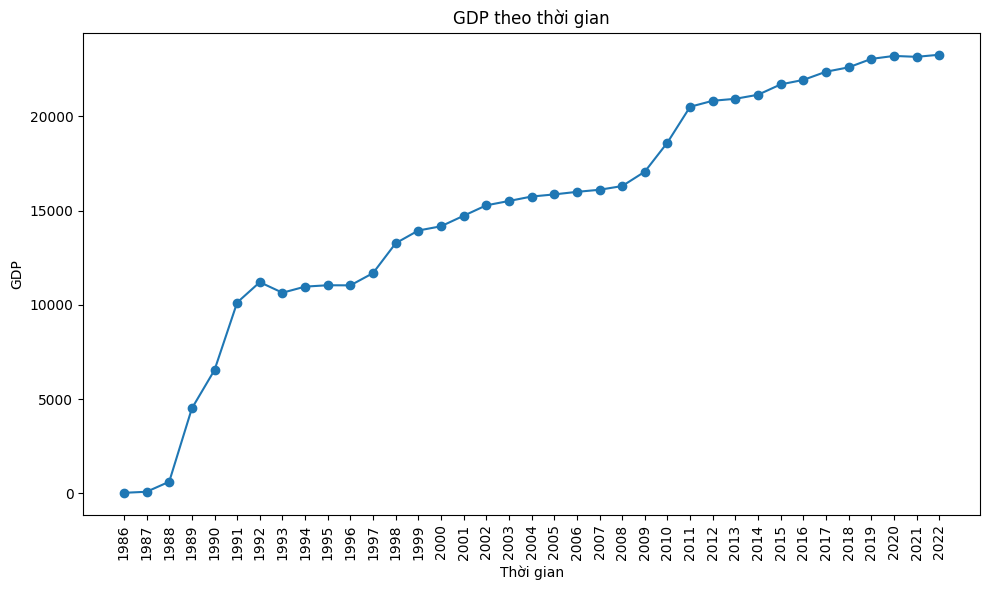

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists
time_step = []
cpi = []

# Open CSV file
with open('exchange_rate.csv', 'r') as csvfile:
    # Initialize reader
    reader = csv.reader(csvfile)

    # Skip the first line
    next(reader)

    # Append values to lists
    for row in reader:
        time_step.append(row[0])  # Thời gian (ví dụ: "Jan-95")
        cpi.append(float(row[1]))  # CPI

# Convert lists to numpy arrays (cho cột CPI)
series = np.array(cpi)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_step, series, marker='o', linestyle='-')
plt.xlabel('Thời gian')
plt.ylabel('GDP')
plt.title('GDP theo thời gian')
plt.xticks(rotation=90)  # Xoay nhãn trục x cho dễ đọc
plt.tight_layout()
plt.show()


In [ ]:
# Define the split time
split_time =int( 0.85*len(series))

# Get the train set
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
import time
start_time = time.time()
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình RNN: {train_time_cls:.4f} giây')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 22092.6211 - mse: 488105984.0000
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 22084.3672 - mse: 487741344.0000
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 22069.3594 - mse: 487078688.0000
Epoch 4/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 22049.2656 - mse: 486192160.0000
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 22025.5039 - mse: 485144864.0000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 21999.1074 - mse: 483982720.0000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 21970.8301 - mse: 482739360.0000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 21941.2441 - mse: 481440128.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 21910.7676 - mse: 480103648.0000
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 21879.6426 - mse: 478740640.0000
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 21847.9570 - mse: 477355072.0000
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 21815.7227 - mse: 475947584.0000
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 21782.9375 - mse: 474518144.0000
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 21749.6289 - mse: 473068096.0000
Epo

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


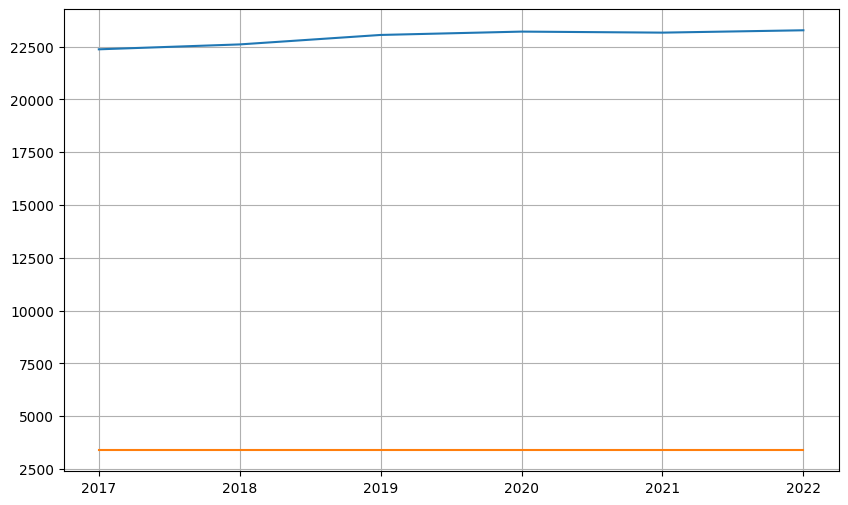

[3389.9688 3389.9688 3389.9688 3389.9688 3389.9688 3389.9688]
MSE: 382458937.95505095
Mean Error Percent: 0.8522156838262126
Accuracy: 0.1477843161737874


In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = np.mean(np.square(x_valid - results))
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)
